In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

%matplotlib inline

pd.set_option('display.max_columns', 200)

C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

## LOAD DATA

In [66]:
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean_cat.csv')
print(train.shape)
print(test.shape)

(91713, 183)
(39308, 183)


In [3]:
set(train.columns)-set(test.columns)

{'hospital_death'}

In [4]:
set(test.columns)-set(train.columns)

{'encounter_id'}

## DATA PREPARATION

In [5]:
# Apache Variables
apache_cov = ['albumin_apache','bilirubin_apache','bun_apache','creatinine_apache','glucose_apache','heart_rate_apache',
          'hematocrit_apache','resprate_apache','sodium_apache','temp_apache','urineoutput_apache','wbc_apache',
          'fio2_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache']
# 4 indicators
apache_indicators = ['apache_post_operative','arf_apache','intubated_apache','ventilated_apache']

# 8 Chronic health status
apache_chronic = ['aids','cirrhosis','diabetes_mellitus','hepatic_failure',
                  'immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']
# 6 others
apache_others =['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem','apache_2_bodysystem',
                'apache_4a_hospital_death_prob','apache_4a_icu_death_prob']

gcs = ['gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache']

apache = apache_cov + apache_indicators + apache_chronic + apache_others + gcs
len(apache)

40

In [6]:
train.isnull().sum()

hospital_id                      0
hospital_death                   0
age                              0
bmi                              0
elective_surgery                 0
                              ... 
leukemia                       715
lymphoma                       715
solid_tumor_with_metastasis    715
apache_3j_bodysystem             0
apache_2_bodysystem              0
Length: 183, dtype: int64

In [7]:
#train.isnull().sum().sort_values(ascending=False)

### Categorical Cols
These are categorical, will need to convert later on:
apache_3j_bodysystem, apache_2_bodysystem, apache_2_diagnosis,apache_3j_diagnosis,apache_3j_diag_type, 
hospital_id

In [67]:
categorical_cols = [col for col in train.columns if  (train[col].dtype != 'float64')&(train[col].dtype != 'int64') ]
print(len(categorical_cols))
categorical_cols

8


['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

### Encode categorical columns

In [68]:
dummies = pd.get_dummies(train[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU', 'apache_3j_bodysystem_Unknown','apache_2_bodysystem_Unknown'])
print(dummies.shape)
train_m = pd.concat([train.drop(columns=categorical_cols),dummies],axis=1)
train_m.shape

(91713, 53)


(91713, 228)

In [69]:
dummies = pd.get_dummies(test[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU', 'apache_3j_bodysystem_Unknown','apache_2_bodysystem_Unknown'])
print(dummies.shape)
test_m = pd.concat([test.drop(columns=categorical_cols),dummies],axis=1)
test_m.shape

(39308, 53)


(39308, 228)

### Create independent features X and dependant feature y

In [70]:
remaining_apache_cols = set(apache)-set(categorical_cols)
len(remaining_apache_cols)

38

In [71]:
# Version 2: Exclude all APACHE variables

X = train_m.drop(columns=remaining_apache_cols).drop(columns='hospital_death',axis=1)
y = train_m.hospital_death

test_m = test_m.drop(columns=remaining_apache_cols).drop("encounter_id", axis=1)

X.shape, test_m.shape

((91713, 189), (39308, 189))

In [ ]:
# Original: all Variables
#X = train_m.drop(columns=['hospital_death'])
#y = train_m.hospital_death

### Remove Columns with more than 75% missing

In [74]:
train_missing = X.isnull().mean().sort_values(ascending = False)
train_missing = train_missing.index[train_missing > 0.75]
#print(train_missing)
X = X.drop(columns = train_missing)

test_m = test_m.drop(columns = train_missing)

print("Feature dimention is: ",X.shape, test_m.shape)

Feature dimention is:  (91713, 149) (39308, 149)


### Impute missing data with SimpleImputer

In [54]:
imputer = SimpleImputer(strategy = 'mean')
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.fit_transform(test_m)


## TRAIN TEST SPLIT

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(68784, 149) (22929, 149)


## StandardScaler

In [56]:
# Instantiate our StandardScaler.
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)  # Scale X_train.
X_test_ss = ss.transform(X_test)  # Scale X_test.

## OVERSAMPLING THE MINORITY CLASS

In [57]:
## Oversampling on minority class
sm = SMOTE(k_neighbors=5,sampling_strategy = "minority",random_state=42)
X_sm, y_sm = sm.fit_sample(X_train_ss, y_train)

#print()
print(np.bincount(y_train.shape, y_sm.shape))

C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[     0.      0.      0. ...      0.      0. 125696.]


## MODELING - Logistic Regression

In [58]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=42)

In [59]:
### 1. Train Logistic Regression on Oversampling dataset
logr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=200)
logr.fit(X_sm, y_sm)
print(cross_val_score(logr, X_sm, y_sm, cv=cv,scoring='roc_auc').mean())

0.8530231432187463


In [60]:
# Apply the model to standardized X
probs = logr.predict_proba(X_train_ss)[:,1]
pred = logr.predict(X_train_ss)
print(roc_auc_score(y_train,pred))
print(roc_auc_score(y_train,probs))

0.7666432441631303
0.8468880582887528


In [76]:
len(X.columns), len(logr.coef_[0])

(149, 149)

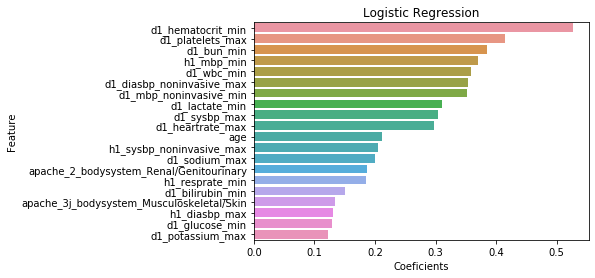

In [62]:
feature_imp_df = pd.DataFrame({"Feature": X.columns, "Coeficients": logr.coef_[0]}).sort_values(by="Coeficients", ascending=False)
sns.barplot(x="Coeficients", y="Feature", data=feature_imp_df.head(20))
plt.title("Logistic Regression")
plt.show()

In [ ]:
# Logistic Regression GridSearchCV
#params = {
#    'penalty': ['l1', 'l2', 'none'],
#    'C': np.logspace(-2,2,10),
#    'solver': ['lbfgs','liblinear']
#}

#logr = LogisticRegression(random_state=42)
#search = GridSearchCV(logr, params,scoring='roc_auc',cv=cv, verbose=10, n_jobs=-1)
#search.fit(X_sm,y_sm)

In [22]:
# Logistic Regression RandomSearchCV
params = {
    'penalty': ['l1', 'l2', 'none'],
    'C': np.logspace(-2,2,10),
    'solver': ['lbfgs','liblinear']
}

logr = LogisticRegression(random_state=42)
search = RandomizedSearchCV(logr, params,n_iter=50, scoring='roc_auc',cv=cv, verbose=10, n_jobs=-1,random_state=42)
search.fit(X_sm,y_sm)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.33,
            train_size=None),
                   error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm...
                   param_distributions={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
             

In [23]:
print(search.best_params_)
print(search.best_score_)
best_logr = search.best_estimator_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 12.915496650148826}
1.0


In [24]:
probs = best_logr.predict_proba(X_test_ss)[:,1]
auc = roc_auc_score(y_test,probs)
fpr,tpr,threshold = roc_curve(y_test,probs)
auc

1.0

In [77]:
(test_imputed.shape)

(39308, 188)

## Apply Model on Test Data

In [75]:
pred_logr = logr.predict_proba(test_imputed)[:,1]
pred_results = pd.DataFrame({'encounter_id':test.encounter_id, 'hospital_death': pred_logr})
pred_results.to_csv('../data/pred_logr.csv',index=False)
pred_results.head()

ValueError: X has 188 features per sample; expecting 149